In [ ]:
!pip install opendatasets
!pip install pandas

In [ ]:
import opendatasets as od
import pandas as pd
od.download("https://www.kaggle.com/datasets/sartajbhuvaji/brain-tumor-classification-mri")


Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: murali5695
Your Kaggle Key: ··········
Dataset URL: https://www.kaggle.com/datasets/sartajbhuvaji/brain-tumor-classification-mri


100%|██████████| 86.8M/86.8M [00:05<00:00, 15.8MB/s]


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
# import mplcyberpunk
# plt.style.use("cyberpunk")
import cv2
import tensorflow as tf
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalMaxPooling2D,GlobalAveragePooling2D, Dropout, Dense, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, TensorBoard, ModelCheckpoint
from sklearn.metrics import classification_report,confusion_matrix
from tqdm import tqdm

from warnings import filterwarnings


In [ ]:
X_train = []
y_train = []
labels = ['glioma_tumor','no_tumor','meningioma_tumor','pituitary_tumor']


image_size = 150
for i in labels:
    folderPath = os.path.join('/content/brain-tumor-classification-mri/Training',i)
    for j in tqdm(os.listdir(folderPath)):
        img = cv2.imread(os.path.join(folderPath,j))
        img = cv2.resize(img,(image_size, image_size))
        X_train.append(img)
        y_train.append(i)

for i in labels:
    folderPath = os.path.join('/content/brain-tumor-classification-mri/Testing',i)
    for j in tqdm(os.listdir(folderPath)):
        img = cv2.imread(os.path.join(folderPath,j))
        img = cv2.resize(img,(image_size,image_size))
        X_train.append(img)
        y_train.append(i)

X_train = np.array(X_train)
y_train = np.array(y_train)

100%|██████████| 74/74 [00:00<00:00, 87.11it/s]


## Data visualization

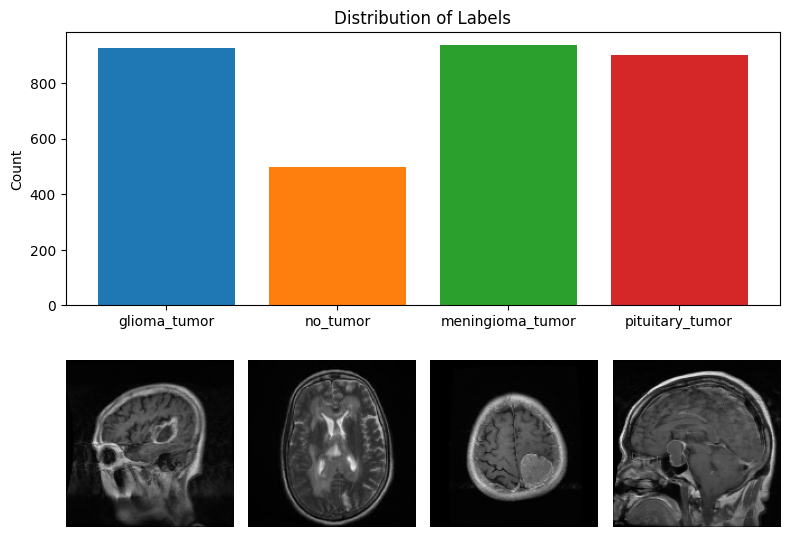

In [ ]:
label_counts = {label: np.sum(y_train == label) for label in labels}

plt.figure(figsize=(8, 6))

colors = ["C0", "C1", "C2", "C3"]

plt.subplot(2, 1, 1)
bars = plt.bar(label_counts.keys(), label_counts.values(), color=colors)
plt.ylabel('Count')
plt.title('Distribution of Labels')

k = 0
for i in labels:
    j = 0
    while True:
        if y_train[j] == i:
            plt.subplot(2, 4, k + 5)
            plt.imshow(X_train[j])
            plt.axis('off')
            k += 1
            break
        j += 1

plt.tight_layout()
plt.show()


### Dataset Split: Train and Test

In [ ]:
X_train, y_train = shuffle(X_train,y_train, random_state=101)

In [ ]:
X_train,X_test,y_train,y_test = train_test_split(X_train,y_train, test_size=0.1,random_state=101)

### One-Hot Encoding Labels

In [ ]:
y_train_new = []
for i in y_train:
    y_train_new.append(labels.index(i))
y_train = y_train_new
y_train = tf.keras.utils.to_categorical(y_train)

y_test_new = []
for i in y_test:
    y_test_new.append(labels.index(i))
y_test = y_test_new
y_test = tf.keras.utils.to_categorical(y_test)

In [ ]:
efficientnetB0 = tf.keras.applications.EfficientNetB0(weights='imagenet',
                                                      include_top=False,
                                                      input_shape=(image_size, image_size, 3))


model = efficientnetB0.output
model = tf.keras.layers.GlobalAveragePooling2D()(model)
model = tf.keras.layers.Dense(1024,activation='relu')(model)
model = tf.keras.layers.Dropout(rate=0.4)(model)
model = tf.keras.layers.Dense(4,activation='softmax')(model)
model = tf.keras.models.Model(inputs=efficientnetB0.input, outputs = model)


model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


In [ ]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 150, 150, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ rescaling (Rescaling)     │ (None, 150, 150, 3)    │              0 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ normalization             │ (None, 150, 150, 3)    │              7 │ rescaling[0][0]        │
│ (Normalization)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ rescaling_1 (Rescaling)   │ (None, 150, 150, 3)    │              0 │ normalization[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_conv_pad             │ (None, 151, 151, 3)    │              0 │ rescaling_1[0][0]      │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_conv (Conv2D)        │ (None, 75, 75, 32)     │            864 │ stem_conv_pad[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_bn                   │ (None, 75, 75, 32)     │            128 │ stem_conv[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_activation           │ (None, 75, 75, 32)     │              0 │ stem_bn[0][0]          │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_dwconv            │ (None, 75, 75, 32)     │            288 │ stem_activation[0][0]  │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_bn                │ (None, 75, 75, 32)     │            128 │ block1a_dwconv[0][0]   │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_activation        │ (None, 75, 75, 32)     │              0 │ block1a_bn[0][0]       │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_squeeze        │ (None, 32)             │              0 │ block1a_activation[0]… │
│ (GlobalAveragePooling2D)  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_reshape        │ (None, 1, 1, 32)       │              0 │ block1a_se_squeeze[0]… │
│ (Reshape)                 │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_reduce         │ (None, 1, 1, 8)        │            264 │ block1a_se_reshape[0]… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_expand    

 Total params: 5,365,415 (20.47 MB)

 Trainable params: 5,323,392 (20.31 MB)

 Non-trainable params: 42,023 (164.16 KB)

In [ ]:
tensorboard = TensorBoard(log_dir='logs')

checkpoint = ModelCheckpoint("efficientnetB0.keras", monitor="val_accuracy",
                             save_best_only=True, verbose=1)

reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.1, patience=2,
                              min_delta=0.0001, verbose=1)

In [ ]:
history = model.fit(X_train,y_train,validation_split = 0.1, epochs = 5, verbose = 1,
                    batch_size = 32, callbacks=[tensorboard,checkpoint,reduce_lr])

Epoch 1/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 713ms/step - accuracy: 0.7302 - loss: 0.6755
Epoch 1: val_accuracy improved from -inf to 0.85034, saving model to efficientnetB0.keras
83/83 ━━━━━━━━━━━━━━━━━━━━ 176s 1s/step - accuracy: 0.7313 - loss: 0.6732 - val_accuracy: 0.8503 - val_loss: 0.7532 - learning_rate: 0.0010
Epoch 2/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step - accuracy: 0.9173 - loss: 0.2312
Epoch 2: val_accuracy did not improve from 0.85034
83/83 ━━━━━━━━━━━━━━━━━━━━ 15s 83ms/step - accuracy: 0.9172 - loss: 0.2315 - val_accuracy: 0.7347 - val_loss: 1.2615 - learning_rate: 0.0010
Epoch 3/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step - accuracy: 0.9471 - loss: 0.1785
Epoch 3: val_accuracy did not improve from 0.85034

Epoch 3: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
83/83 ━━━━━━━━━━━━━━━━━━━━ 7s 82ms/step - accuracy: 0.9471 - loss: 0.1783 - val_accuracy: 0.8061 - val_loss: 0.7713 - learning_rate: 0.0010
Epoch 4/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - accu

In [ ]:

import numpy as np
from sklearn.metrics import classification_report

y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test, axis=1)

# Generate a classification report
report = classification_report(y_true_classes, y_pred_classes, target_names=labels)
print(report)


# Evaluate the model on the test set
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=2)

print('\nTest accuracy:', test_acc)
print('\nTest loss:', test_loss)


11/11 ━━━━━━━━━━━━━━━━━━━━ 23s 896ms/step
                  precision    recall  f1-score   support

    glioma_tumor       0.86      0.96      0.91        93
        no_tumor       0.85      1.00      0.92        51
meningioma_tumor       1.00      0.78      0.88        96
 pituitary_tumor       0.98      1.00      0.99        87

        accuracy                           0.92       327
       macro avg       0.92      0.93      0.92       327
    weighted avg       0.93      0.92      0.92       327

11/11 - 5s - 466ms/step - accuracy: 0.9235 - loss: 0.2164

Test accuracy: 0.9235473871231079

Test loss: 0.21636393666267395


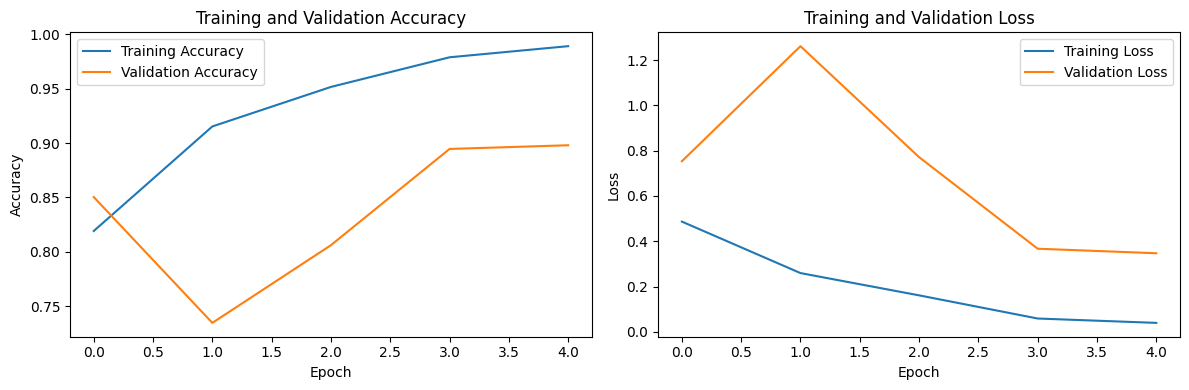

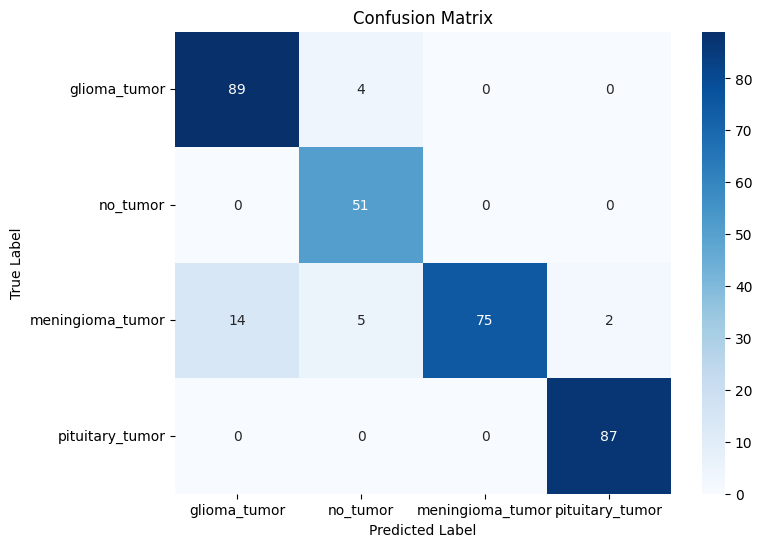

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Plot training accuracy and loss
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.tight_layout()
plt.show()

# Create and plot the confusion matrix
cm = confusion_matrix(y_true_classes, y_pred_classes)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()


Macro F1-Score: 0.9232
Weighted F1-Score: 0.9222
Test Loss: 0.2164
Test Accuracy: 0.9235


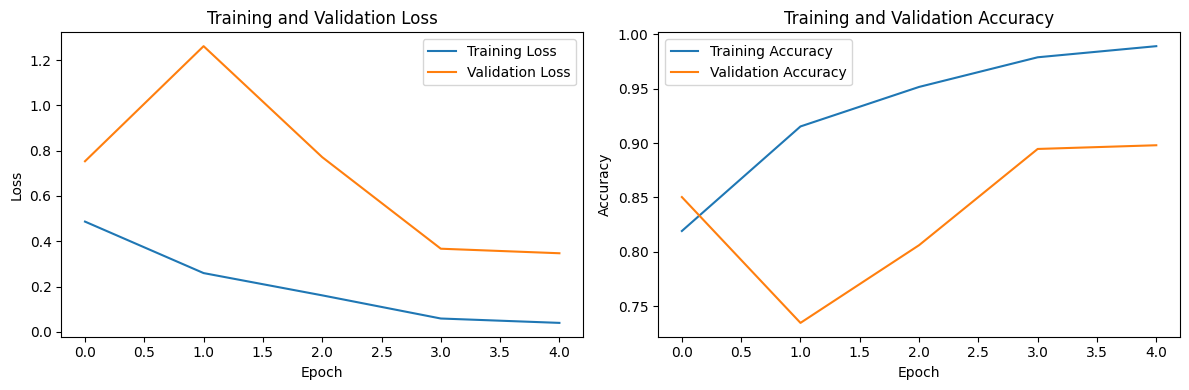

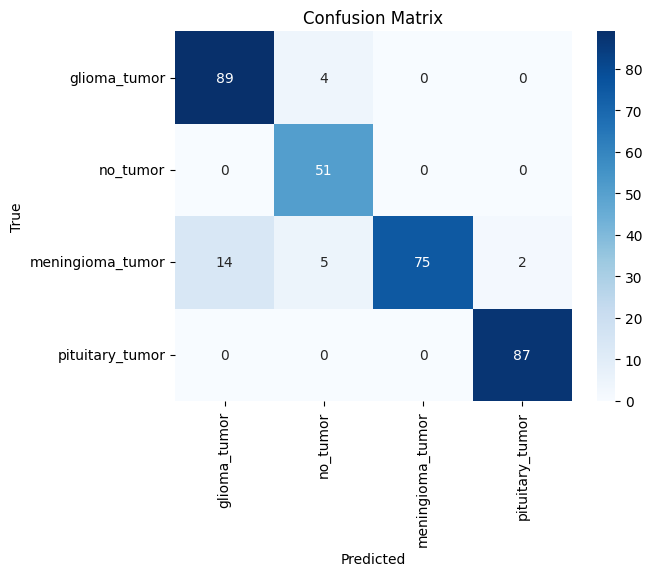

In [ ]:

import matplotlib.pyplot as plt
# ... (Your existing code) ...

# After model training and evaluation, you can extract relevant metrics for your paper.

# 1. F1-Score:
#    - You already have a classification report, which includes F1-score for each class.
#    - You can also calculate the average F1-score for overall performance.
from sklearn.metrics import f1_score
f1_macro = f1_score(y_true_classes, y_pred_classes, average='macro')
f1_weighted = f1_score(y_true_classes, y_pred_classes, average='weighted')

print(f"Macro F1-Score: {f1_macro:.4f}")
print(f"Weighted F1-Score: {f1_weighted:.4f}")


# 2. Loss:
#    - Training loss and validation loss throughout the epochs are useful to demonstrate model learning.
#    - Test loss (obtained from model.evaluate) reflects the model's performance on unseen data.
print(f"Test Loss: {test_loss:.4f}")

# 3. Accuracy:
#    - Training accuracy, validation accuracy, and test accuracy are essential metrics.
print(f"Test Accuracy: {test_acc:.4f}")

# 4. Graphs:
#    - Create graphs to visualize training and validation loss/accuracy over epochs.
#    - Confusion Matrix plot for a visual representation of model performance.
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

# Confusion matrix
cm = confusion_matrix(y_true_classes, y_pred_classes)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


In [ ]:
cd /content/drive/MyDrive/1000

/content/drive/MyDrive/1000


In [ ]:
# prompt: savemodel

model.save('efficientnetB092.h5')
